In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Set the path to your dataset
dataset_dir = ""

# Set the input size for resizing the images
input_size = (128,128)

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

In [4]:
# Load the training dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the test dataset
test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Load the pre-trained ResNet model
model = resnet18(pretrained=True)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_accuracy = train_correct / len(train_dataset)
    train_loss /= len(train_loader)

    # Evaluation on the test set
    model.eval()
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / len(test_dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f}")

Epoch [1/20] Train Loss: 0.6750 Train Accuracy: 0.7488 Test Accuracy: 0.8385
Epoch [2/20] Train Loss: 0.2021 Train Accuracy: 0.9323 Test Accuracy: 0.7358
Epoch [3/20] Train Loss: 0.1601 Train Accuracy: 0.9544 Test Accuracy: 0.9459
Epoch [4/20] Train Loss: 0.1690 Train Accuracy: 0.9521 Test Accuracy: 0.8737
Epoch [5/20] Train Loss: 0.1609 Train Accuracy: 0.9580 Test Accuracy: 0.9329
Epoch [6/20] Train Loss: 0.0781 Train Accuracy: 0.9800 Test Accuracy: 0.9544
Epoch [7/20] Train Loss: 0.0467 Train Accuracy: 0.9859 Test Accuracy: 0.9455
Epoch [8/20] Train Loss: 0.0530 Train Accuracy: 0.9856 Test Accuracy: 0.9103
Epoch [9/20] Train Loss: 0.0460 Train Accuracy: 0.9859 Test Accuracy: 0.9315
Epoch [10/20] Train Loss: 0.0926 Train Accuracy: 0.9721 Test Accuracy: 0.9804
Epoch [11/20] Train Loss: 0.0097 Train Accuracy: 0.9961 Test Accuracy: 0.9552
Epoch [12/20] Train Loss: 0.0266 Train Accuracy: 0.9915 Test Accuracy: 0.9029
Epoch [13/20] Train Loss: 0.0576 Train Accuracy: 0.9892 Test Accuracy: 0.

In [8]:
# Path for the saved model
path = './models/resnet18.pt'
# torch.save(model.state_dict(), path)

In [19]:
# Calculate the final accuracy on the entire test dataset
model.load_state_dict(torch.load(path))
model.eval()
test_correct = 0

preds_tensor = torch.Tensor()
labels_tensor = torch.Tensor()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        preds_tensor = torch.cat((preds_tensor, predicted))
        labels_tensor = torch.cat((labels_tensor, labels))
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = test_correct / len(test_dataset)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Final Test Accuracy: 0.9833


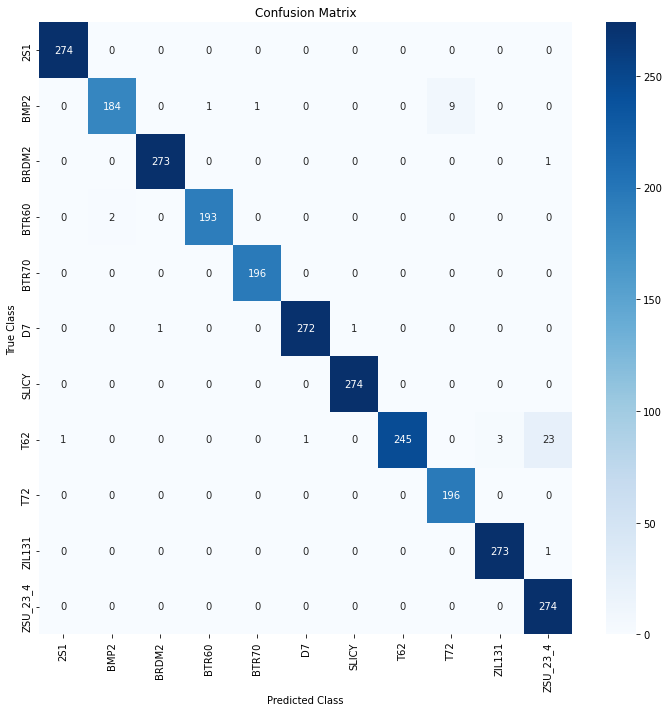

In [32]:
preds = preds_tensor.numpy()
actual = labels_tensor.numpy()

# Define the mapping dictionary
class_mapping = {
    0: '2S1',
    1: 'BMP2',
    2: 'BRDM2',
    3: 'BTR60',
    4: 'BTR70',
    5: 'D7',
    6: 'SLICY',
    7: 'T62',
    8: 'T72',
    9: 'ZIL131',
    10: 'ZSU_23_4'
}

y_preds = np.array([class_mapping[value] for value in preds])
y_true = np.array([class_mapping[value] for value in actual])

class_labels = ['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70', 'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_preds, labels=class_labels)

# Set figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Configure figure properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()

# Show the figure
plt.show()


In [36]:
class_wise_accuracies = np.diag(cm) / cm.sum(axis=1)

# Display the class-wise accuracies
for i, accuracy in enumerate(class_wise_accuracies):
    label = class_labels[i]
    print(f'Accuracy of class {label}: {accuracy:.2%}')


Accuracy of class 2S1: 100.00%
Accuracy of class BMP2: 94.36%
Accuracy of class BRDM2: 99.64%
Accuracy of class BTR60: 98.97%
Accuracy of class BTR70: 100.00%
Accuracy of class D7: 99.27%
Accuracy of class SLICY: 100.00%
Accuracy of class T62: 89.74%
Accuracy of class T72: 100.00%
Accuracy of class ZIL131: 99.64%
Accuracy of class ZSU_23_4: 100.00%
